Importing Libraries
--

In [1]:
from pre_process import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from DBCV import DBCV

Loading Libraries...Just a moment please!...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Path for the article file
--

In [2]:
path = "/Users/gurpreetbedi/Downloads/Neural/Indeed_local/source_data/"

In [3]:
art_train = load_data(f"{path}article.json")
art_train = remove_hyperlinks_html_tags(art_train, "content")
art_train["cont_title"] = art_train["contentTitle"] + " " + art_train["content"]

Training articles shape
--

In [4]:
art_train.shape

(13639, 8)

Using the combintion of Content and Title for analysis
--

In [5]:
content = list(art_train["cont_title"])

In [6]:
def predict_topics_with_kmeans(embeddings,num_topics):
    """
    Predict the article with respective topics using kmeans
    """
    kmeans_model = KMeans(num_topics)
    kmeans_model.fit(embeddings)
    topics_labels = kmeans_model.predict(embeddings)
    return topics_labels

def predict_topics_with_agglo(embeddings,num_topics):
    """
    Predict the article with respective topics using Agglomerative Clustering
    """
    agglo_model = AgglomerativeClustering(num_topics)
    agglo_model.fit(embeddings)
    topics_labels = agglo_model.labels_
    return topics_labels

def predict_topics_with_hdb(embeddings):
    """
    Predict the article with respective topics using HDBSCAN
    """
    hdb_model = hdbscan.HDBSCAN()
    hdb_model.fit(embeddings)
    topics_labels = hdb_model.labels_
    return topics_labels

def plot_embeddings(embedding, labels,title):
    """
    Plotting the embeddings with corresponding labels
    """
    labels = np.array(labels)
    distinct_labels =  set(labels)
    
    n = len(embedding)
    counter = Counter(labels)
    for i in range(len(distinct_labels)):
        ratio = (counter[i] / n)* 100
        cluster_label = f"cluster {i}: {round(ratio,2)}"
        x = embedding[:, 0][labels == i]
        y = embedding[:, 1][labels == i]
        plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
    plt.title(title)
    
def reduce_umap(embedding):
    """
    Implementing UMAP dimensionality reduction
    """    
    reducer = umap.UMAP()
    embedding_umap = reducer.fit_transform(embedding)
    return embedding_umap

def reduce_pca(embedding):
    """
    Implementing PCA dimensionality reduction
    """        
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embedding)
    print( "pca explained_variance_ ",pca.explained_variance_)
    print( "pca explained_variance_ratio_ ",pca.explained_variance_ratio_)
    
    return reduced

def reduce_pca_for_tsne(embedding):
    """
    Implementing PCA dimensionality reduction for TSNE
    """            
    pca = PCA(n_components=50)
    reduced = pca.fit_transform(embedding)
    print( "pca explained_variance_ ",pca.explained_variance_)
    print( "pca explained_variance_ratio_ ",pca.explained_variance_ratio_)
    
    return reduced

def reduce_tsne(embedding):
    """
    Implementing TSNE dimensionality reduction
    """                
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform(embedding)
    return reduced

Sentence transformer model
--

In [7]:
class Sentence_Encoder:
    """ Sentence Embedder used for creating embedding models
    Arguments:
        embedding_model: The main embedding model to be used for extracting
                         document and embedding
    """
    def __init__(self,embedding_model=None):
        if isinstance(embedding_model, str):
            self.embedding_model = SentenceTransformer(embedding_model)
        else:
            raise ValueError("Please select a correct SentenceTransformers model: msmarco-MiniLM-L-6-v3")


    def embed_documents(self, document: List[str], verbose: bool = False) -> np.ndarray:
        """ Embed a list of n words into an n-dimensional
        matrix of embeddings
        Arguments:
            document: A list of documents to be embedded
            verbose: Controls the verbosity of the process
        Returns:
            Document embeddings with shape (n, m) with `n` documents
            that each have an embeddings size of `m`
        """
        embeddings = self.embedding_model.encode(documents, show_progress_bar=verbose)
        return embeddings

In [8]:
embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
sent_embeddings = Sentence_Encoder(embedding_model).embed_documents(documents, device = device)
sent_embeddings =  np.array(sent_embeddings)

Shape and Example of Sentence Transformer Embeddings
--

In [9]:
print("Sentence Transformers Embedding shape", sent_embeddings.shape)
print("Sentence Transformers Embedding sample", sent_embeddings[0][0:50])

Sentence Transformers Embedding shape (13639, 384)
Sentence Transformers Embedding sample [-0.317892   -0.04125648 -0.16228807 -0.05585816  0.05258717  0.04738453
  0.00116334 -0.33725244 -0.01225118 -0.20963445 -0.23128155  0.125802
  0.11605517 -0.33296704  0.13521688  0.11744959 -0.21096413  0.021813
 -0.20530568 -0.13482088 -0.10901643 -0.20952997 -0.07429067  0.24946193
  0.22043636 -0.06303668  0.4224041   0.0415949  -0.43110287 -0.06507912
 -0.09269568  0.06359139  0.39354515 -0.27553767  0.16108465  0.33772334
  0.10521714  0.1704944  -0.00766862 -0.4572493  -0.04907504 -0.08805001
 -0.01514139 -0.05203443 -0.04005496 -0.29925027 -0.00853006 -0.33872202
 -0.0743498   0.16568503]


Raw Embeddings without dimension reduction
--

Duration: 5.5216240882873535 seconds


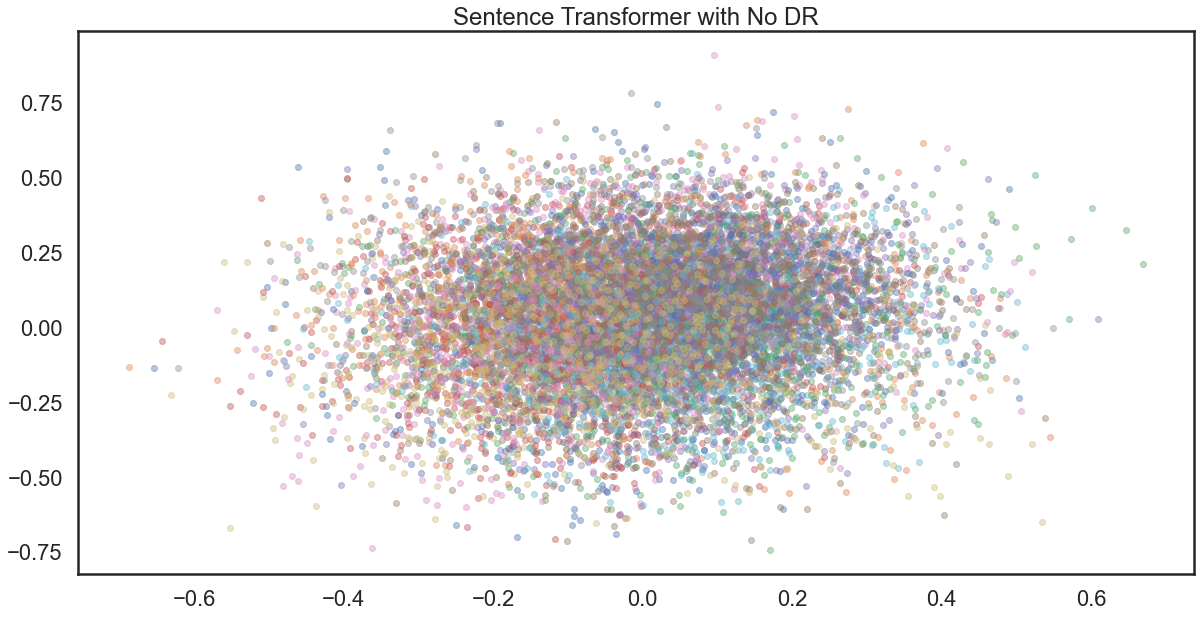

In [10]:
num_topics = 30
start = time.time()
labels_raw  = predict_topics_with_kmeans(sent_embeddings,num_topics)
print('Duration: {} seconds'.format(time.time() - start))
fig, ax = plt.subplots(figsize=(20, 10))
plot_embeddings(sent_embeddings, labels_raw,"Sentence Transformer with No DR")

Sentence transformers embeddings with UMAP dimension reduction
--

Duration: 16.536839962005615 seconds


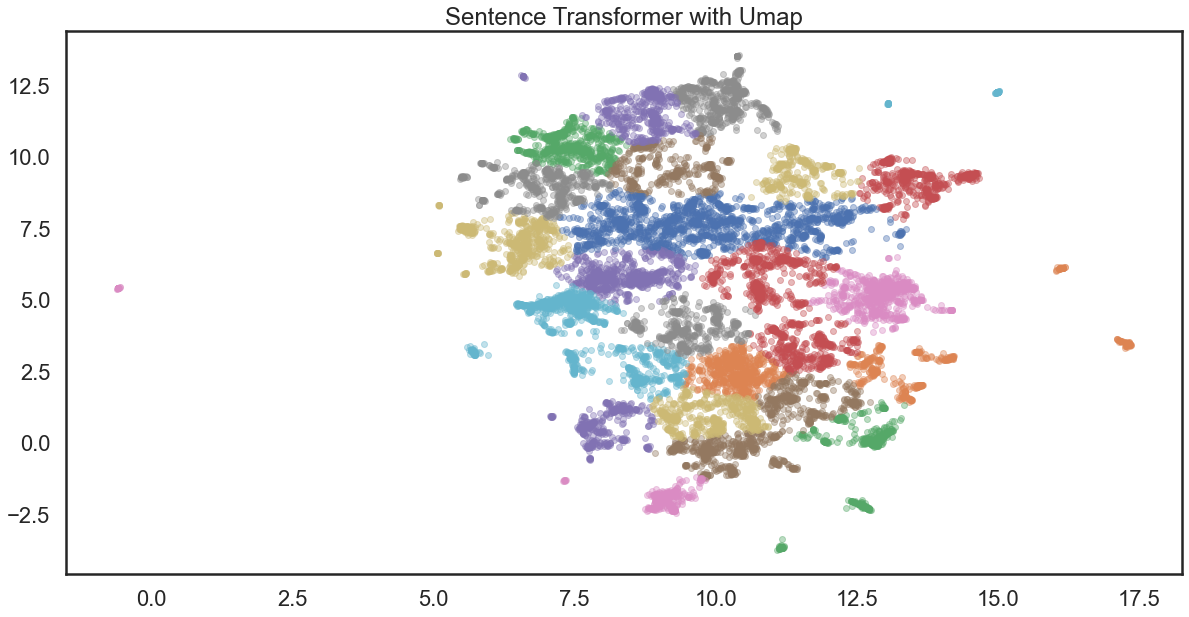

In [11]:
start = time.time()
embedding_umap = reduce_umap(sent_embeddings)
print('Duration: {} seconds'.format(time.time() - start))
labels_umap  = predict_topics_with_kmeans(embedding_umap, num_topics)
fig, ax = plt.subplots(figsize=(20, 10))
plot_embeddings(embedding_umap, labels_umap,"Sentence Transformer with Umap")

Sentence transformers embeddings with PCA dimension reduction
--

pca explained_variance_  [0.7722671 0.6562691]
pca explained_variance_ratio_  [0.05426504 0.04611419]
Duration: 0.12449193000793457 seconds


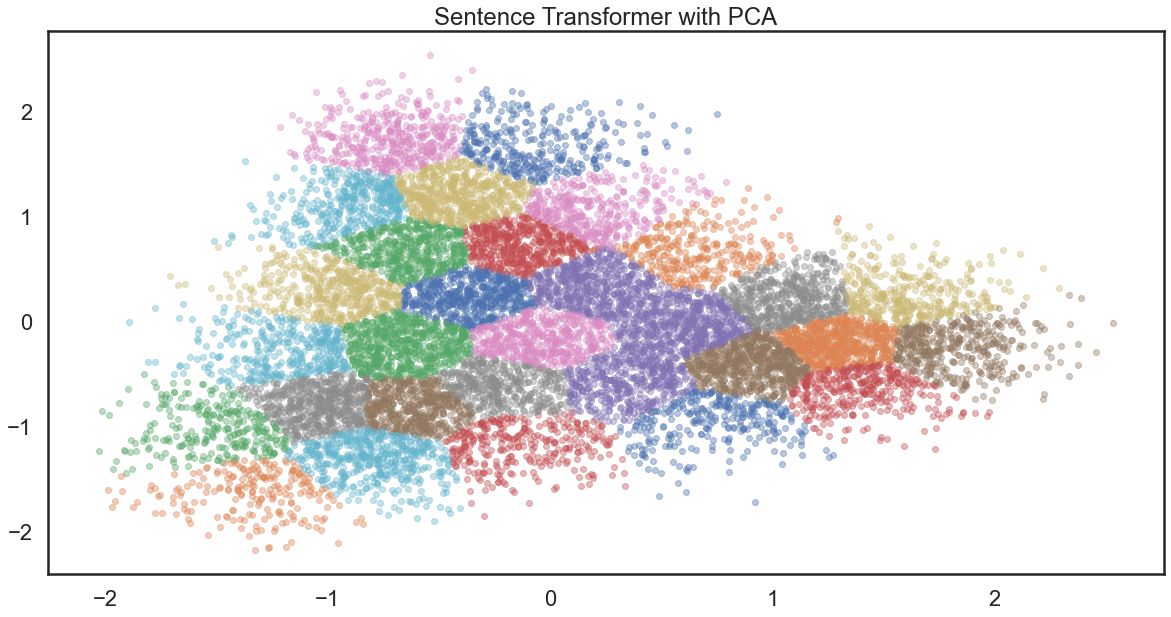

In [12]:
start = time.time()
embedding_pca =  reduce_pca(sent_embeddings)
print('Duration: {} seconds'.format(time.time() - start))
labels_pca  = predict_topics_with_kmeans(embedding_pca, num_topics)
fig, ax = plt.subplots(figsize=(20, 10))
plot_embeddings(embedding_pca,labels_pca,"Sentence Transformer with PCA")

Sentence transformers embeddings with TSNE dimension reduction
--

pca explained_variance_  [0.7722664  0.65626895 0.58009684 0.49747303 0.4066858  0.37226266
 0.3426102  0.31019095 0.28707463 0.27482843 0.25282404 0.2445241
 0.23769037 0.2221832  0.21403867 0.20866588 0.19324525 0.18535967
 0.17937882 0.17428483 0.16885684 0.16457541 0.15896952 0.1541916
 0.14917383 0.14395207 0.14300224 0.1404637  0.13817355 0.13620508
 0.13006349 0.12667762 0.12253494 0.1191678  0.11628345 0.11315188
 0.11096231 0.11001784 0.10794518 0.1033142  0.09924017 0.09803916
 0.09645578 0.09463242 0.09285264 0.09050892 0.08846413 0.08462918
 0.08345974 0.08256883]
pca explained_variance_ratio_  [0.05426499 0.04611418 0.04076178 0.03495603 0.02857667 0.02615785
 0.02407426 0.02179625 0.02017193 0.01931142 0.01776524 0.01718202
 0.01670184 0.01561219 0.0150399  0.01466237 0.0135788  0.0130247
 0.01260445 0.01224651 0.0118651  0.01156425 0.01117034 0.01083461
 0.01048203 0.01011511 0.01004837 0.00986999 0.00970907 0.00957075
 0.0091392  0.00890128 0.00861019 0.00837359 0.00817

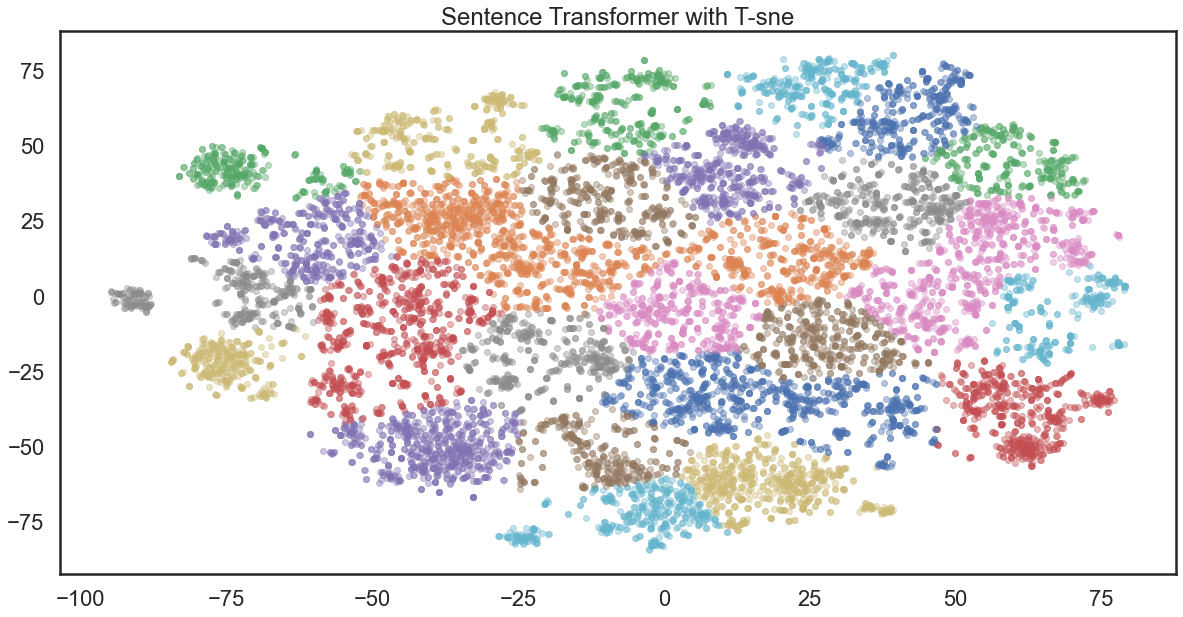

In [13]:
#Apply Kmeans for Bert Vectors  with T-sne  dimension reduction
start = time.time()
pca_reduces_50 = reduce_pca_for_tsne(sent_embeddings)
embedding_tsne =  reduce_tsne(pca_reduces_50)
print('Duration: {} seconds'.format(time.time() - start))
labels_tsne  = predict_topics_with_kmeans(embedding_tsne, num_topics)
fig, ax = plt.subplots(figsize=(20, 10))
plot_embeddings(embedding_tsne,labels_tsne,"Sentence Transformer with T-sne")

In [14]:
print("Silhouette score:" )
print("Raw Bert" ,silhouette_score(sent_embeddings, labels_raw))
print("Sentence Transformer with PCA" ,  silhouette_score(embedding_pca, labels_pca))
print("Sentence Transformer with Tsne" , silhouette_score(embedding_tsne, labels_tsne))
print("Sentence Transformer with Umap" ,  silhouette_score(embedding_umap , labels_umap))

Silhouette score:
Raw Bert 0.043594915
Sentence Transformer with PCA 0.32357255
Sentence Transformer with Tsne 0.37226942
Sentence Transformer with Umap 0.43807986


In [15]:
umap_data = umap.UMAP().fit_transform(sent_embeddings)

In [16]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

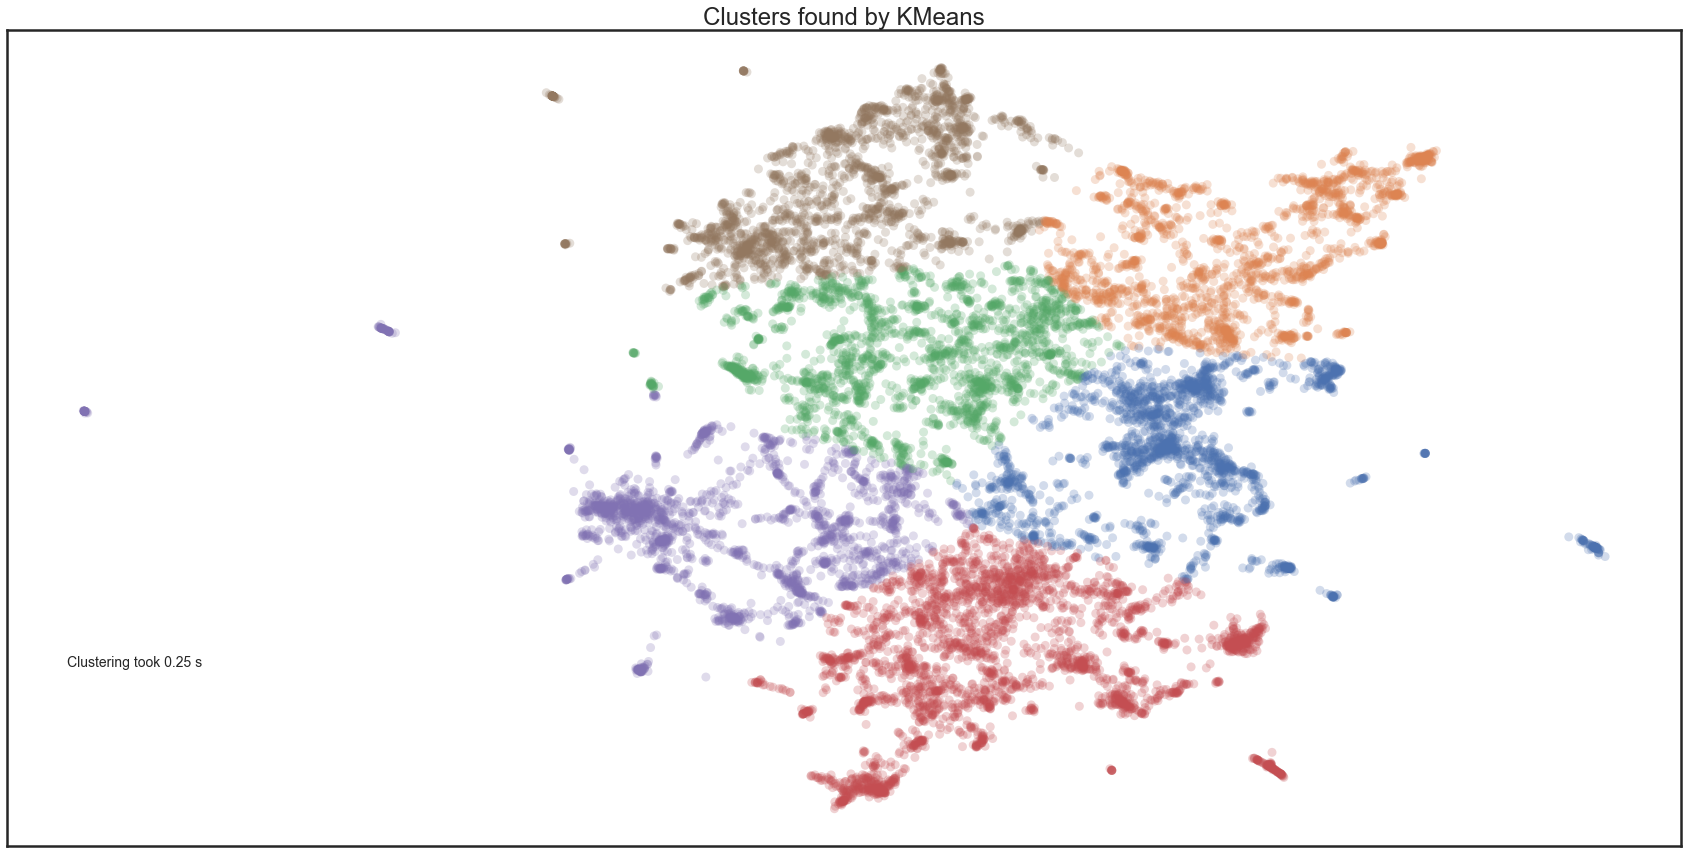

In [17]:
fig, ax = plt.subplots(figsize=(30, 15))
plot_clusters(umap_data, cluster.KMeans, (), {'n_clusters':6})

**The graph clearly shows how k-means is trying to join points to the cluster where the data points belong or not, which is what is not required as per the requirement. Therefore, if we don’t know how many clusters the dataset that we are exploring has, k-means would be a problem to use in our case.**

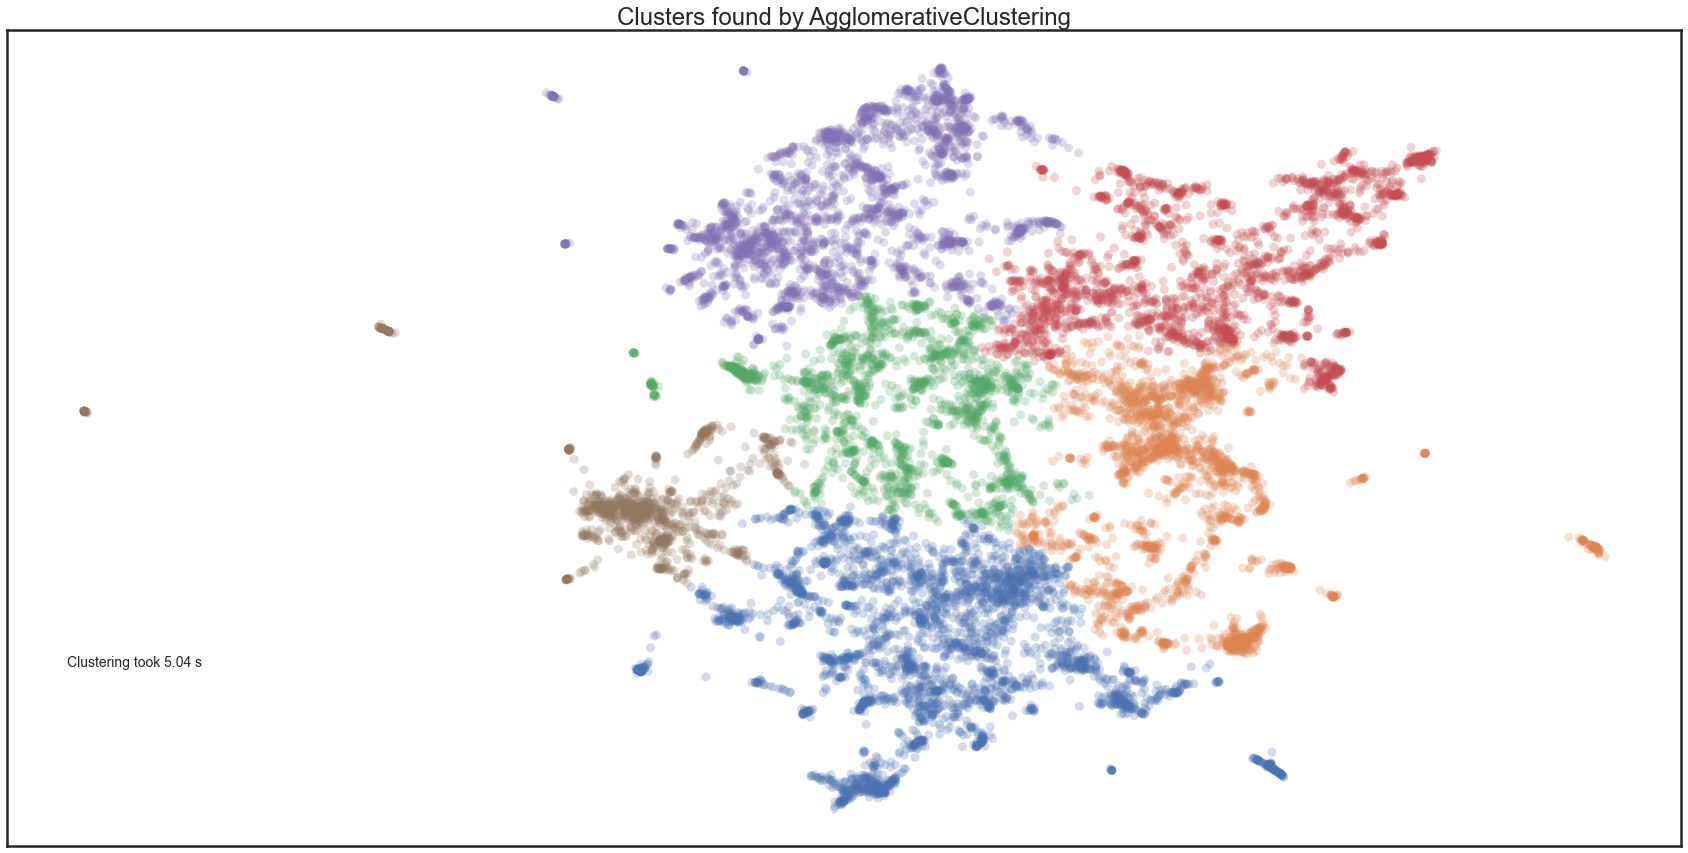

In [18]:
fig, ax = plt.subplots(figsize=(30, 15))
plot_clusters(umap_data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

**The graph on the right shows the representation of Agglomerative Clustering. It is similar to k-means, that is we have to choose a number of clusters (which is not easy in Exploratory Data Analysis), or try to recognize some parameter value from the plot that may or may not have any obvious natural choices.**

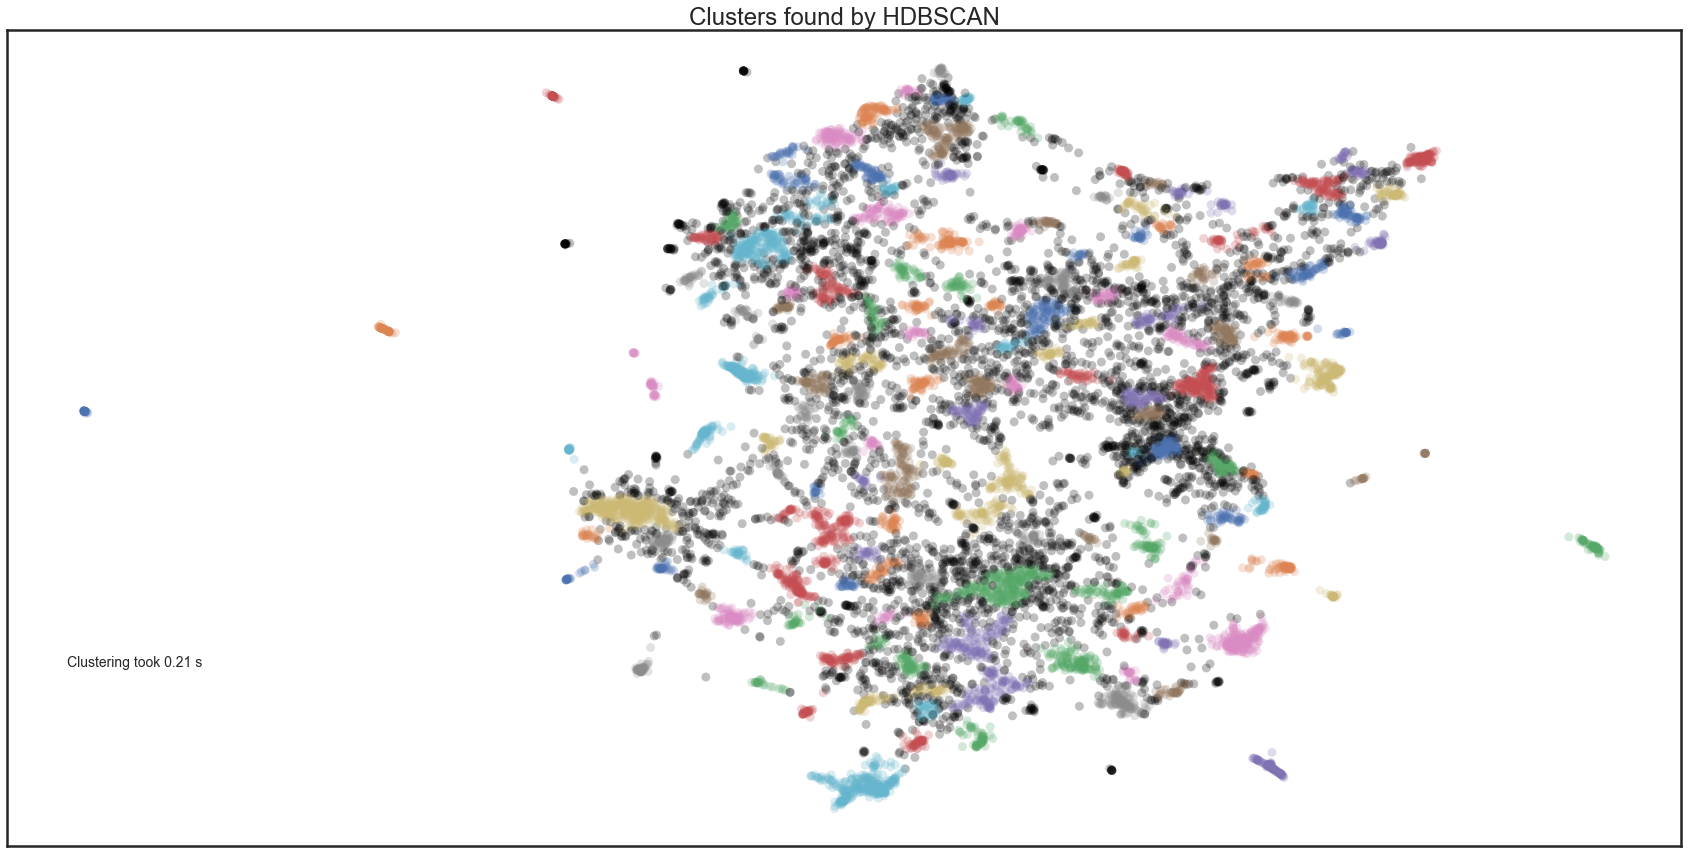

In [19]:
fig, ax = plt.subplots(figsize=(30, 15))
plot_clusters(umap_data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

**HDBSCAN being a density based algorithm which works quite well with UMAP in comparison to other clustering algorithms like k-mean and agglomerative clustering, since UMAP maintains a lot of local structure even in lower-dimensional space. Also, one of the advantages here of HDBSCAN is that it does not force data points to clusters as it considers them outliers.**

In [21]:
embedding_umap = reduce_umap(sent_embeddings)

In [22]:
start = time.time()
hdb_labels_umap  = predict_topics_with_hdb(embedding_umap)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 0.22652697563171387 seconds


In [23]:
num_topics = len(np.unique(hdb_labels_umap))
start = time.time()
kmeans_labels_umap  = predict_topics_with_kmeans(embedding_umap, num_topics)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 6.5417609214782715 seconds


In [24]:
start = time.time()
agglo_labels_umap  = predict_topics_with_agglo(embedding_umap, num_topics)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 5.465852737426758 seconds


In [25]:
print("Silhouette score:" )
print("Sentence Transformer with HDBSCAN" ,  silhouette_score(embedding_umap, hdb_labels_umap))
print("Sentence Transformer with K-Means" , silhouette_score(embedding_umap, kmeans_labels_umap))
print("Sentence Transformer with Agglo" ,  silhouette_score(embedding_umap , agglo_labels_umap))

Silhouette score:
Sentence Transformer with HDBSCAN 0.17330036
Sentence Transformer with K-Means 0.4681
Sentence Transformer with Agglo 0.45320252


Evaluation Metric for Clustering ALgorithms
--

**Note: We cannot use Silhoutte scores for evaluating HDBSCAN as they are just used to evaluate globular cluster, but fail to evaluate non-globular (arbitarily shaped) clusters and HDBSCAN forms non-globular clusters. Therefore, we used DBCV for evaluating clustering algorithms.**

**DBCV is Density based clustering validation algorithm which is used to evaluate the density within the clusters and density between the clusters**

**Note: DBCV execution takes time as it is trying to calculate density within the clusters and density between the clusters.**
**Issue: https://github.com/christopherjenness/DBCV/issues/13**

**Therefore we would be using the subset of Indeed data and would be performing the analysis**

In [26]:
np.random.seed(seed=42)

np.random.shuffle(embedding_umap)
umap_data = embedding_umap[:1000,:]

In [27]:
hdb_labels_umap  = predict_topics_with_hdb(umap_data)
num_topics = len(np.unique(hdb_labels_umap))
kmeans_labels_umap  = predict_topics_with_kmeans(umap_data, num_topics)
agglo_labels_umap  = predict_topics_with_agglo(umap_data, num_topics)

In [28]:
from scipy.spatial.distance import euclidean
start = time.time()

kmeans_score = DBCV(umap_data, kmeans_labels_umap, dist_function=euclidean)
print('K-means Duration: {} seconds'.format(time.time() - start))

K-means Duration: 78.66319012641907 seconds


In [29]:
start = time.time()
agglo_score = DBCV(umap_data, agglo_labels_umap, dist_function=euclidean)
print('Agglomerative Duration: {} seconds'.format(time.time() - start))

Agglomerative Duration: 76.07499098777771 seconds


In [30]:
start = time.time()
hdbscan_score = DBCV(umap_data, hdb_labels_umap, dist_function=euclidean)
print('HDBSCAN Duration: {} seconds'.format(time.time() - start))

HDBSCAN Duration: 76.90859961509705 seconds


In [31]:
print(f"""
K-Means score : {kmeans_score}
Agglomerative score : {agglo_score}
HDBSCAN score : {hdbscan_score}
""")


K-Means score : -0.7043012987160389
Agglomerative score : -0.7868360272980826
HDBSCAN score : -0.26855241759983106

